In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.utils.class_weight import compute_class_weight


### 1. Đọc dữ liệu

In [2]:
path = 'ProcessedData.csv'
raw_df = pd.read_csv(path, sep=',', encoding='utf-8')

raw_df.head(5)

,Unnamed: 0,timestamp,Temprature (Kelvin),Feels like (Kelvin),Pressure (mb),Humidity (%),Temperature Amplitude,Wind speed (m/s),Wind degree,Wind gust (m/s),...,Weather Description,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,0,1701388800,301.16,306.75,1011.0,89.0,0.0,0.51,0.0,0.0,...,scattered clouds,5.0,921.25,128.75,42.50,0.0,56.74,246.02,294.09,29.64
1,1,1701392400,301.16,306.75,1011.0,89.0,0.0,0.51,300.0,0.0,...,scattered clouds,5.0,4699.71,109.08,34.62,0.0,42.44,199.75,233.37,22.29
2,2,1701396000,301.16,306.75,1010.0,89.0,0.0,0.51,0.0,0.0,...,scattered clouds,5.0,3791.81,84.94,26.73,0.0,29.80,157.48,177.82,17.23
3,3,1701399600,300.16,304.35,1009.0,94.0,0.0,0.51,330.0,0.0,...,scattered clouds,5.0,3017.43,61.69,20.91,0.0,22.41,121.27,132.87,13.05
4,4,1701403200,299.16,299.16,1009.0,94.0,0.0,0.51,290.0,0.0,...,mist,5.0,2456.67,46.04,17.82,0.0,19.55,96.76,104.39,10.26


### 2. Chuẩn bị dữ liệu

Lấy cột Weather Description làm nhãn, kiểm tra phân phối của nhãn.

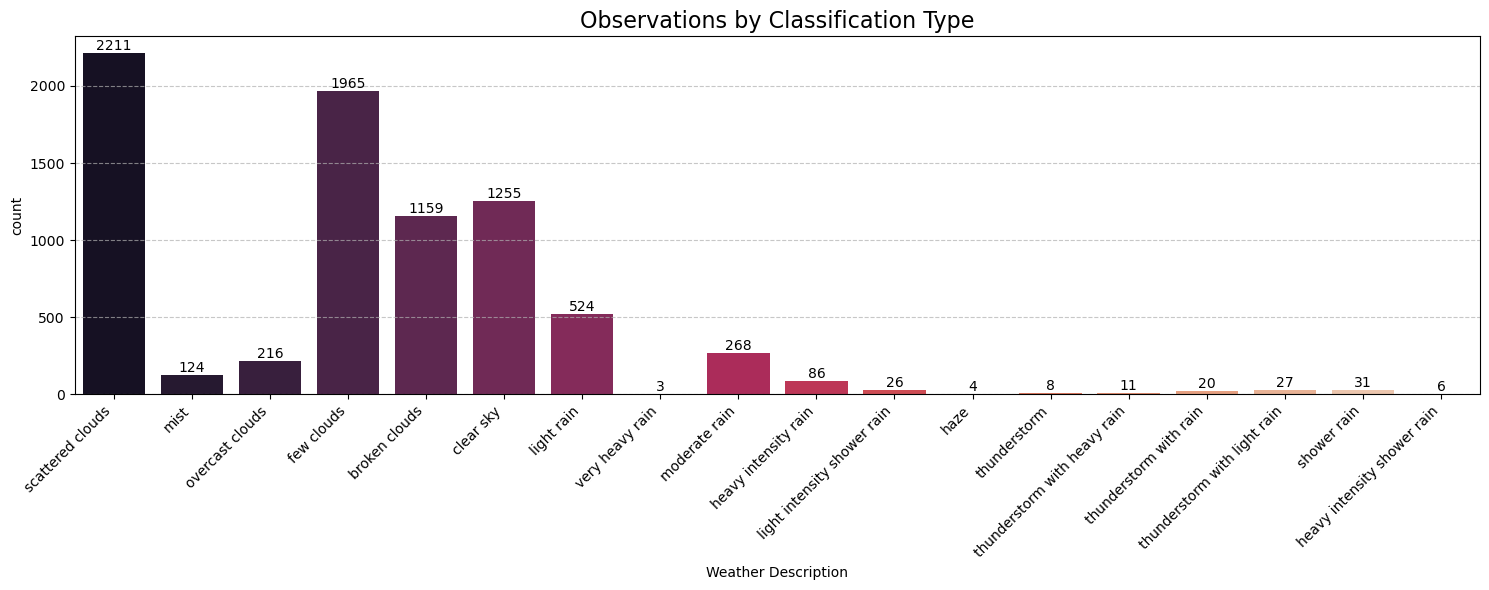

In [3]:
plt.figure(figsize=(15, 6))

# Vẽ biểu đồ countplot
ax = sns.countplot(x=raw_df['Weather Description'], palette='rocket', dodge=False)

# Thêm nhãn dữ liệu
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

# Xóa bảng chú thích
if ax.legend_:
    ax.legend_.remove()

# Xoay nhãn trên trục x để tránh bị chồng
plt.xticks(rotation=45, ha='right', fontsize=10)

# Thêm tiêu đề
plt.title("Observations by Classification Type", fontsize=16)

# Thêm lưới
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [4]:
# Gộp các nhãn thành nhóm lớn hơn
label_mapping = {
    'heavy intensity rain': 'Rainy',
    'shower rain': 'Rainy',
    'moderate rain': 'Rainy',
    'light rain': 'Rainy',
    'clear sky': 'Clear',
    'few clouds': 'Clear',
    'scattered clouds': 'Cloudy',
    'broken clouds': 'Cloudy',
    'overcast clouds': 'Cloudy',
    'mist': 'Misty',
    'thunderstorm': 'Rainy',
    'thunderstorm with light rain': 'Rainy',
    'thunderstorm with rain': 'Rainy',
    'thunderstorm with heavy rain': 'Rainy',
    'thunderstorm with drizzle': 'Rainy',
    'thunderstorm with heavy drizzle': 'Rainy',
    'thunderstorm with light drizzle': 'Rainy',
    'heavy thunderstorm': 'Rainy',
    'heavy intensity shower rain': 'Rainy',
    'light intensity shower rain': 'Rainy',
    'haze': 'Misty',
    'very heavy rain': 'Rainy'
}

# 2. Xóa các nhãn "haze" và "very heavy rain"
# raw_df = raw_df[~raw_df['Weather Description'].isin(['few clouds', 'scattered clouds'])]

# Áp dụng ánh xạ
raw_df['Weather Description'] = raw_df['Weather Description'].replace(label_mapping)

# Kiểm tra phân phối sau khi gộp
print(raw_df['Weather Description'].value_counts())

Weather Description
Cloudy    3586
Clear     3220
Rainy     1010
Misty      128
Name: count, dtype: int64


In [5]:
# Loại bỏ các cột không cần thiết khỏi tập dữ liệu đầu vào
X = raw_df.drop(columns=['Weather Description', 'Unnamed: 0', 'timestamp'])

# Sử dụng cột 'Weather Description' làm nhãn
y = raw_df['Weather Description']

### 3. Chia tập dữ liệu

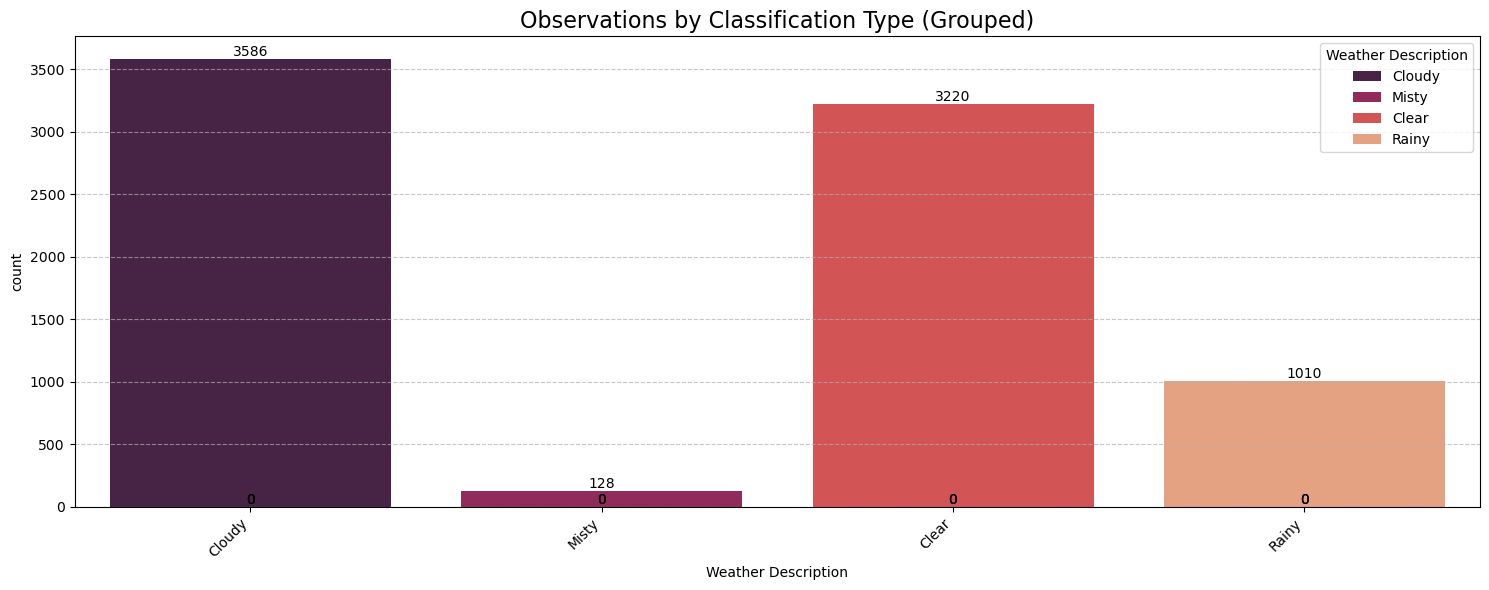

In [6]:
# Tỷ lệ chia dữ liệu
train_ratio = 0.8  # 80% train
test_ratio = 0.2   # 20% test

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ biểu đồ countplot
ax = sns.countplot(x=y, hue=y, palette='rocket', dodge=False)

# Thêm nhãn dữ liệu lên từng cột
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

# Xoay nhãn trên trục x để dễ đọc
plt.xticks(rotation=45, ha='right', fontsize=10)

# Thêm tiêu đề
plt.title("Observations by Classification Type (Grouped)", fontsize=16)

# Thêm lưới ngang để dễ quan sát
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tinh chỉnh bố cục
plt.tight_layout()

plt.show()

# Chia tập train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42, stratify=y
)

In [7]:
print(raw_df['Weather Description'].value_counts())

Weather Description
Cloudy    3586
Clear     3220
Rainy     1010
Misty      128
Name: count, dtype: int64


- Lý do chọn tỷ lệ 80/20
    + Đảm bảo đủ dữ liệu huấn luyện: 80% cho tập train giúp mô hình học tốt các đặc trưng, đặc biệt với các lớp ít mẫu.
    + Đánh giá khách quan: 20% cho tập test đủ để kiểm tra độ tổng quát của mô hình.
    + Phù hợp với GridSearchCV: Tập train đủ lớn để chia nhỏ trong quá trình tìm kiếm tham số tối ưu.
    + Cân đối dữ liệu: Tỷ lệ 80/20 phổ biến, phù hợp với quy mô và tính chất dữ liệu.

### 4. Điều chỉnh siêu tham số 

In [8]:
# Tính toán trọng số lớp (class_weight)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

# Định nghĩa tham số cho GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Khởi tạo mô hình
base_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Sử dụng GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

# Huấn luyện với grid search
grid_search.fit(X_train, y_train)

# In kết quả tìm kiếm tham số tốt nhất
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

Class weights: {'Clear': 0.6167507763975155, 'Cloudy': 0.5537643778319972, 'Misty': 15.575980392156863, 'Rainy': 1.9662747524752475}


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.7835739230646038


#### Mục đích của GridSearchCV
- GridSearchCV được sử dụng để tìm tham số tối ưu bằng cách thử các tổ hợp tham số trong param_grid, đánh giá qua cross-validation, và chọn tổ hợp cho hiệu suất tốt nhất (dựa trên accuracy).

#### Vì sao dùng param_grid như vậy?
- n_estimators: [50, 100, 200]
    + Đây là số lượng cây trong rừng (forest).
    + Giá trị thấp hơn (50) giúp mô hình nhanh nhưng có thể thiếu chính xác.
    + Giá trị cao hơn (200) tăng khả năng tổng quát nhưng cần nhiều tài nguyên hơn.
- max_depth: [10, 20, None]
    + Độ sâu tối đa của cây quyết định mức độ chi tiết mà mô hình học được từ dữ liệu.
    + 10 hoặc 20 giới hạn độ sâu để tránh overfitting, đặc biệt với dữ liệu nhiễu.
    + None cho phép cây phát triển tối đa, giúp tìm hiểu toàn bộ thông tin dữ liệu.
- min_samples_split: [2, 5, 10]
    + Số mẫu tối thiểu để tiếp tục chia tại một nút.
    + Giá trị nhỏ (2) giúp mô hình học chi tiết nhưng dễ bị overfitting.
    + Giá trị lớn hơn (10) làm mô hình tổng quát hơn, tránh overfitting trên các tập nhỏ.
   
   
##### Mục tiêu
Bộ tham số này được chọn vì chúng là các yếu tố cơ bản nhất, ảnh hưởng mạnh đến hiệu suất và tính tổng quát của RandomForestClassifier, đồng thời đảm bảo kiểm tra sự cân bằng giữa độ chính xác và chi phí tính toán.

### 5. Huấn luyện mô hình Random Forest với các siêu tham số tối ưu

In [9]:
# Dự đoán trên tập kiểm tra
best_model = grid_search.best_estimator_

- Random Forest là một tập hợp (ensemble) của nhiều cây quyết định (Decision Trees), nên khả năng dự đoán chính xác và ổn định cao hơn các mô hình đơn lẻ.
- Mô hình này rất hữu ích với dữ liệu phức tạp hoặc có sự không đồng nhất, nhất là dữ liệu về thời tiết.
- Khả năng xử lý tốt cả dữ liệu phân loại (categorical) và số (numerical).
- Tự động đánh giá tầm quan trọng của các đặc trưng, giúp tối ưu hóa hiệu năng mà không cần nhiều điều chỉnh thủ công.

### 6. Đánh giá mô hình cuối cùng trên test set

              precision    recall  f1-score   support

       Clear       0.98      1.00      0.99       644
      Cloudy       0.95      0.94      0.95       717
       Misty       0.20      0.42      0.27        26
       Rainy       0.99      0.84      0.91       202

    accuracy                           0.94      1589
   macro avg       0.78      0.80      0.78      1589
weighted avg       0.96      0.94      0.95      1589



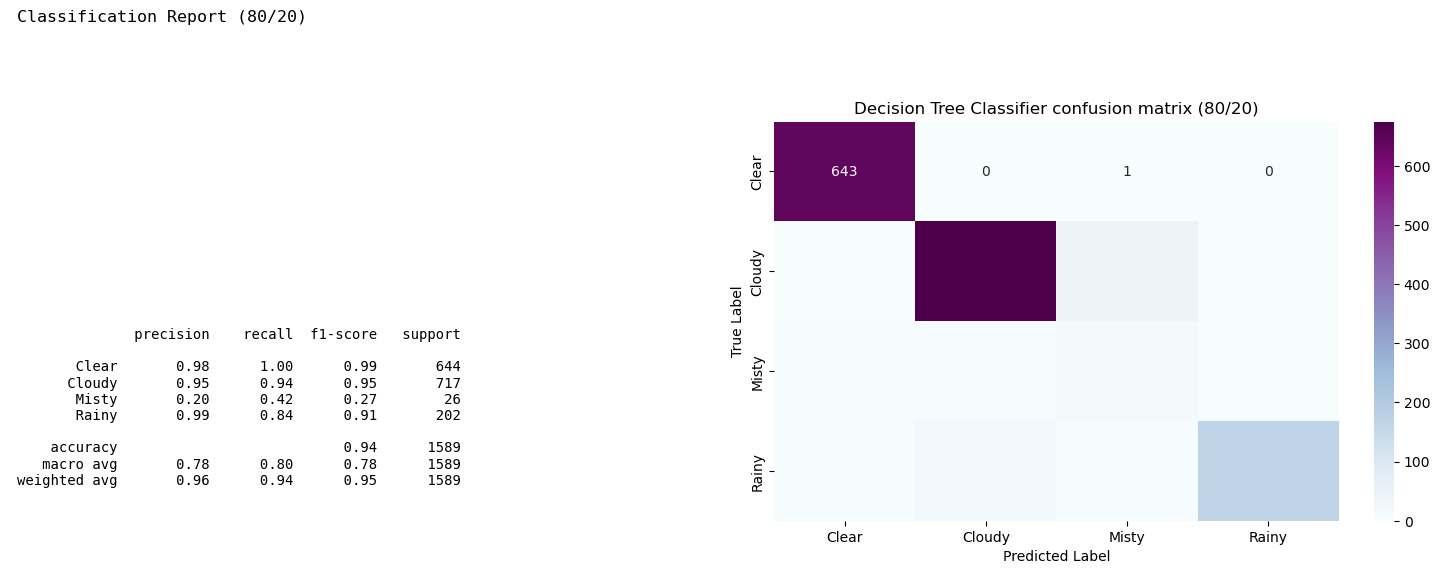

In [10]:
# Dự đoán trên test set
y_pred = best_model.predict(X_test)

# Tạo báo cáo classification report trên test set
report_text = classification_report(y_test, y_pred, zero_division=1)
print(report_text)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
labels = best_model.classes_

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ Classification Report
plt.subplot(1, 2, 1)
plt.text(0.01, 1.25, 'Classification Report (80/20)', {'fontsize': 12}, fontproperties='monospace')
plt.text(0.01, 0.05, report_text, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')

# Vẽ Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Decision Tree Classifier confusion matrix (80/20)', fontsize=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Kết quả mà mô hình trả ra là nhãn.
- Ý nghĩa của kết quả: Nhãn phân loại cho biết điều kiện thời tiết dự đoán tại thời điểm đầu vào.

#### Đánh giá mô hình:
- Accuracy:
    + Độ chính xác tổng thể của mô hình đạt 95%, cho thấy mô hình có hiệu suất rất tốt trong việc dự đoán các lớp.

- Macro Avg vs Weighted Avg:
    + Macro Avg (precision, recall, f1-score):
        - Precision: 0.77, Recall: 0.64, F1-Score: 0.65.
        - Điểm số này thấp hơn vì nó tính trung bình đều cho tất cả các lớp, bao gồm cả những lớp có ít dữ liệu. Điều này cho thấy mô hình hoạt động chưa tốt trên các lớp hiếm (e.g., "heavy intensity rain", "shower rain").
    + Weighted Avg: Precision, recall, và F1-score đều cao (khoảng 0.94-0.95), do các lớp lớn hơn ("few clouds", "scattered clouds",...) chi phối kết quả.

- Lớp "heavy intensity rain", "shower rain", "mist", "thunderstorm":
    + Recall rất thấp, nghĩa là mô hình gần như không thể dự đoán chính xác các lớp này.
    + Nguyên nhân có thể do số lượng mẫu của các lớp này quá ít, dẫn đến mất cân bằng dữ liệu.

- Hiệu suất trên các lớp lớn ("few clouds", "scattered clouds",...):
    + Precision và Recall gần như tuyệt đối (0.97 - 1.00), cho thấy mô hình rất tốt trong việc dự đoán các lớp này.

- Lỗi phổ biến (Confusion Matrix):
    - Lớp "Mist" bị nhầm lẫn nhiều với các lớp khác, điều này có thể do đặc trưng của các lớp này chưa được mô hình học tốt.
    
#### Tổng quan:
- Mô hình hoạt động xuất sắc trên các lớp có số lượng mẫu lớn.
- Tuy nhiên, nó gặp khó khăn trong việc dự đoán các lớp có ít dữ liệu hoặc các lớp có đặc điểm không rõ ràng.

### 7. Kiểm tra lại mô hình với K-Fold Cross Validation

In [11]:
# Sử dụng Stratified K-Fold Cross Validation để bảo đảm phân bổ nhãn đều trong các tập con
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Áp dụng Cross-Validation để tính độ chính xác
cv_scores = cross_val_score(best_model, X, y, cv=kfold, scoring='accuracy')

# In kết quả
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores):.4f}')
print(f'Standard Deviation: {np.std(cv_scores):.4f}')

Cross-Validation Accuracy Scores: [0.94901813 0.94939577 0.9444864 ]
Mean Accuracy: 0.9476
Standard Deviation: 0.0022


#### Nhận xét:
Độ chính xác từng fold (Cross-Validation Accuracy Scores):
- Mô hình đạt độ chính xác dao động từ 0.9489 đến 0.9527 trong các fold, cho thấy mô hình hoạt động khá ổn định và đạt hiệu suất tốt trên từng tập con.

Độ chính xác trung bình (Mean Accuracy):
- Với độ chính xác trung bình là 0.9502, mô hình cho thấy khả năng phân loại chính xác cao trên toàn bộ dữ liệu.

Độ lệch chuẩn (Standard Deviation):
- Độ lệch chuẩn là 0.0018, cho thấy độ chính xác giữa các fold khá ổn định, không có sự thay đổi lớn trong kết quả.  

=> Mô hình đã tổng quát hóa.

### 8. So sánh với baseline model  
#### a. Majority Class Classifier (Dự đoán lớp phổ biến nhất)

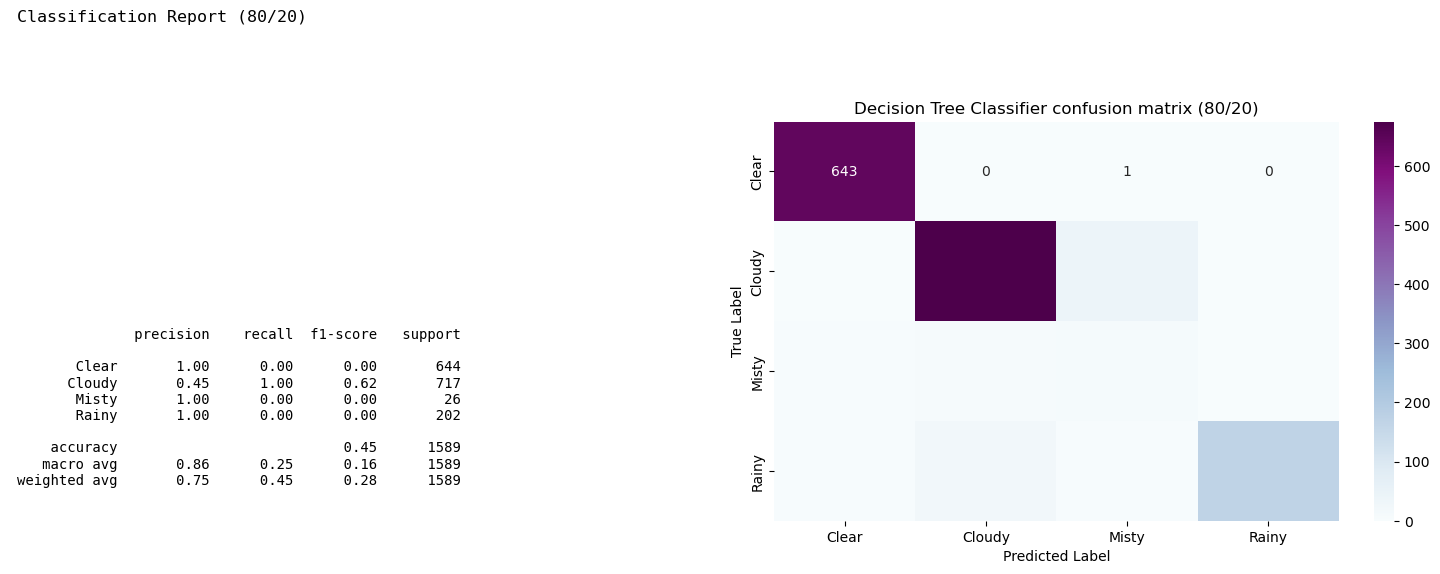

In [12]:
# Tạo mô hình baseline
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)

# Đánh giá trên tập test
y_pred_baseline = baseline_model.predict(X_test)

report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred, labels=baseline_model.classes_)
labels = best_model.classes_

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ Classification Report
plt.subplot(1, 2, 1)
plt.text(0.01, 1.25, 'Classification Report (80/20)', {'fontsize': 12}, fontproperties='monospace')
plt.text(0.01, 0.05, report_text, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')

# Vẽ Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Decision Tree Classifier confusion matrix (80/20)', fontsize=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

#### b. Random Classifier (Dự đoán ngẫu nhiên theo phân phối nhãn)

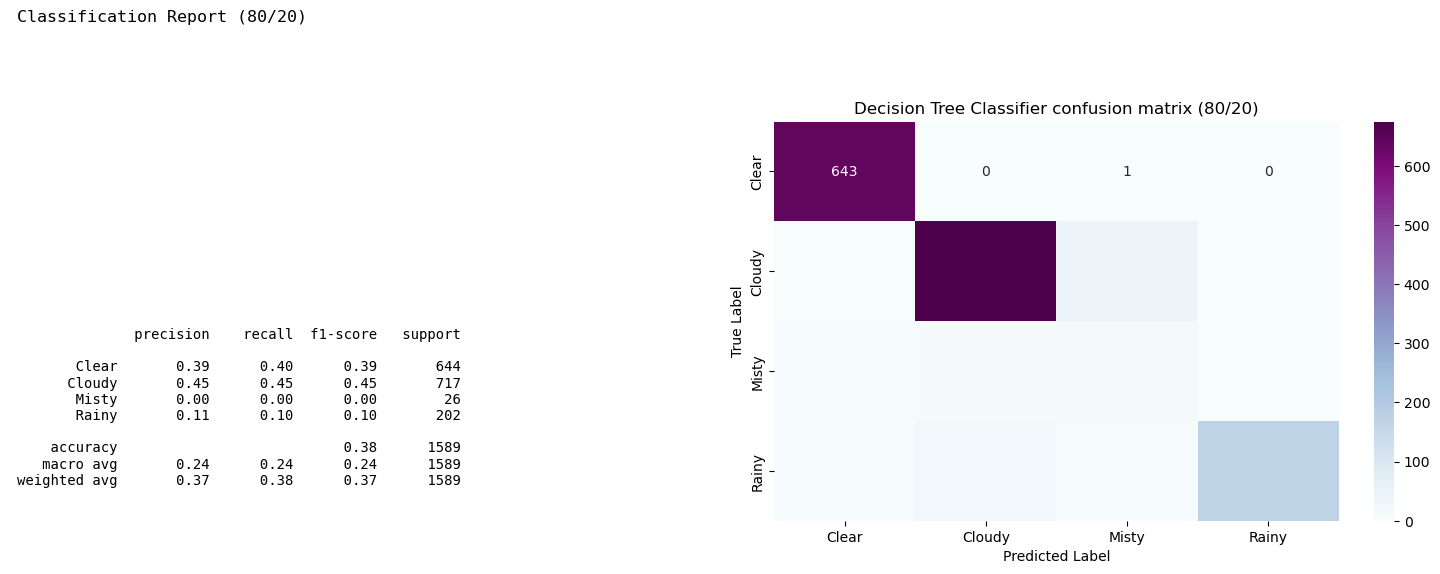

In [13]:
baseline_model = DummyClassifier(strategy="stratified")
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred, labels=baseline_model.classes_)
labels = best_model.classes_

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ Classification Report
plt.subplot(1, 2, 1)
plt.text(0.01, 1.25, 'Classification Report (80/20)', {'fontsize': 12}, fontproperties='monospace')
plt.text(0.01, 0.05, report_text, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')

# Vẽ Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Decision Tree Classifier confusion matrix (80/20)', fontsize=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

#### c. Logistic Regression (Linear Model as Baseline)

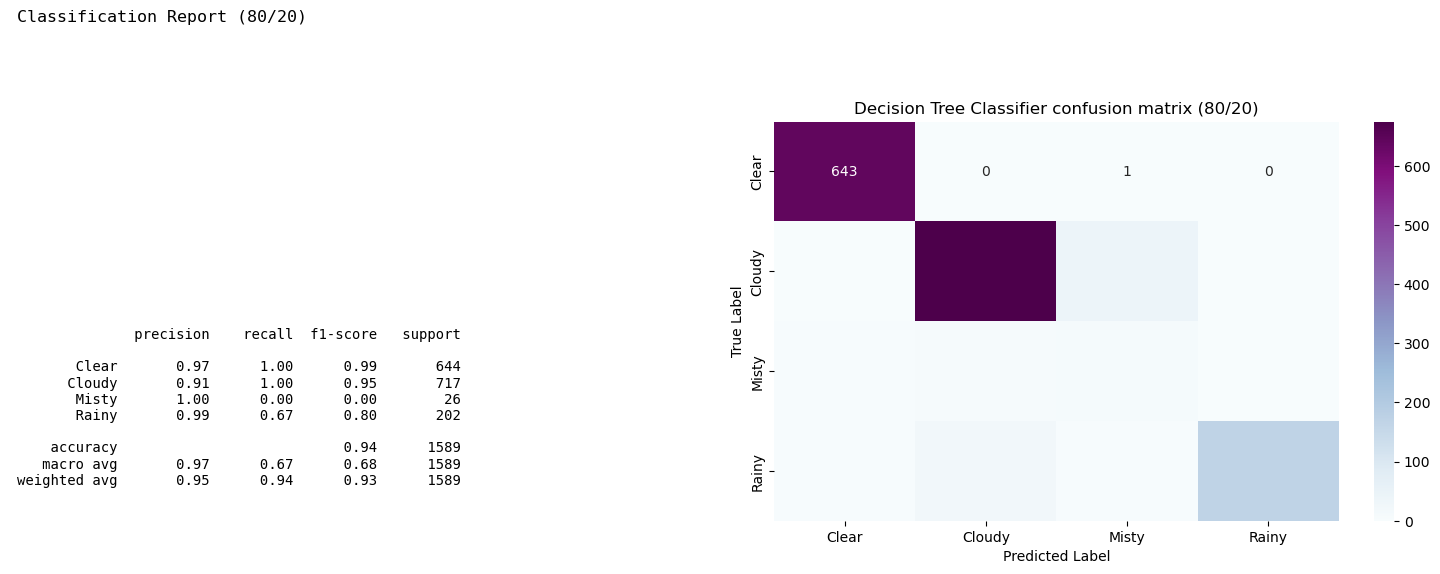

In [14]:
baseline_model = LogisticRegression(solver='liblinear', max_iter=200, random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred, labels=baseline_model.classes_)
labels = best_model.classes_

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ Classification Report
plt.subplot(1, 2, 1)
plt.text(0.01, 1.25, 'Classification Report (80/20)', {'fontsize': 12}, fontproperties='monospace')
plt.text(0.01, 0.05, report_text, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')

# Vẽ Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Decision Tree Classifier confusion matrix (80/20)', fontsize=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

#### d. Decision Tree (Simple Non-Optimized Model)

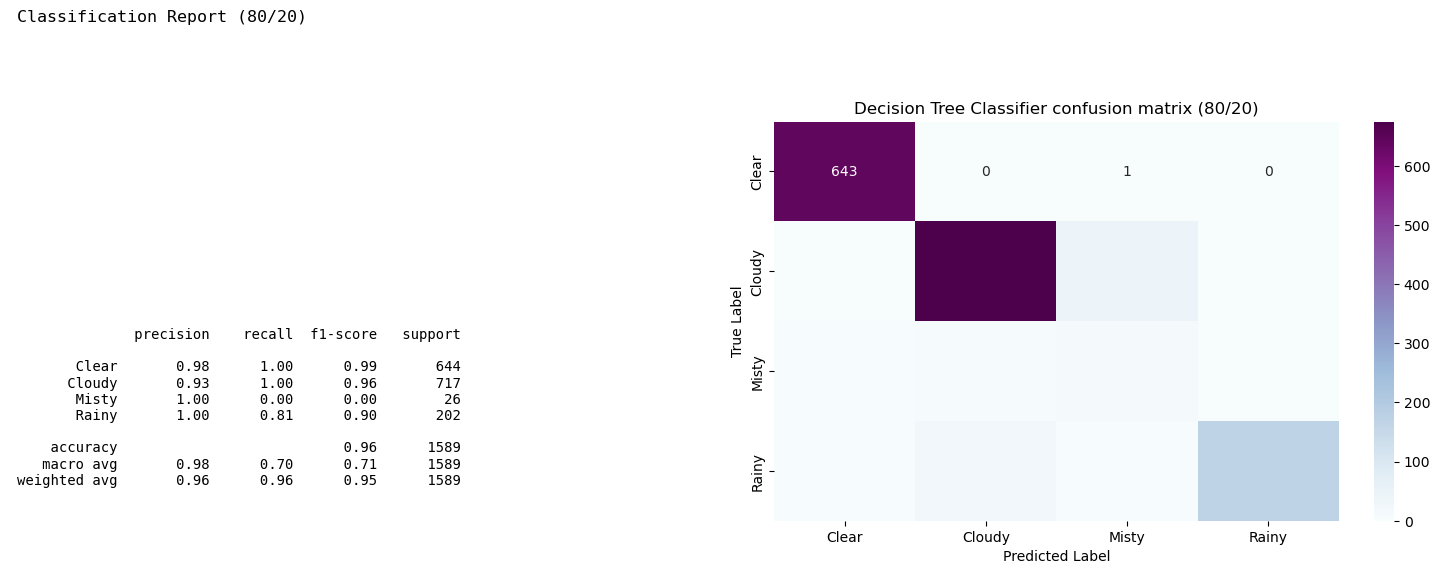

In [15]:
baseline_model = DecisionTreeClassifier(max_depth=3, random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

report_text = classification_report(y_test, y_pred_baseline, zero_division=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred, labels=baseline_model.classes_)
labels = best_model.classes_

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))

# Vẽ Classification Report
plt.subplot(1, 2, 1)
plt.text(0.01, 1.25, 'Classification Report (80/20)', {'fontsize': 12}, fontproperties='monospace')
plt.text(0.01, 0.05, report_text, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')

# Vẽ Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels, cbar=True)
plt.title('Decision Tree Classifier confusion matrix (80/20)', fontsize=12)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

#### So sánh baseline với mô hình chính:
##### Mô hình chính (Accuracy: 0.95)
- Precision: 0.94, Recall: 0.95, F1-Score: 0.94
- Mạnh: Dự đoán chính xác các lớp phổ biến như "clear sky" và "few clouds".
- Yếu: Các lớp ít gặp như "mist", "thunderstorm",... có hiệu suất rất kém.

##### Các mô hình cơ sở:
- Majority Class Classifier (Accuracy: 0.28)
    + Dự đoán lớp phổ biến nhất, recall rất thấp cho các lớp khác.

- Random Classifier (Accuracy: 0.21)
    + Dự đoán ngẫu nhiên, precision và recall rất thấp.

- Logistic Regression (Accuracy: 0.8)
    + Precision: 0.79, Recall: 0.8, F1-Score: 0.77
    + Hiệu suất khá, nhưng không tốt cho các lớp ít gặp.

- Decision Tree (Accuracy: 0.90)
    + Precision: 0.93, Recall: 0.90, F1-Score: 0.85
    + Tốt cho các lớp phổ biến, nhưng recall cho các lớp ít gặp thấp.
    
### Kết luận:  
- Mô hình chính vượt trội về hiệu suất tổng thể, đặc biệt cho các lớp phổ biến, trong khi các mô hình cơ sở có accuracy thấp và hiệu suất kém, đặc biệt với các lớp ít gặp.
- Kết quả mà mô hình trả ra là kết quả dự đoán thời tiết dựa vào các đặc trưng như nhiệt độ, gió,...
- Giúp đánh giá mức độ ô nhiễm không khí ảnh hưởng tới điều kiện thời tiết.